In [1]:
from generator import gaussian_noise_generator
from generator import sphere_point_generator
from generator import gaussian_point_generator
from functions import noisy_function
from functions import sphere_function
from functions import quadratic
from functions import nesterov_function
from functions import bell_curve
import algorithms as alg
from functions import compute_L
import numpy as np
from utilities import plot_real_values
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import seaborn as sns
sns.set_style("whitegrid")
import time

In [2]:
def draw_contour(func, results, figsize, function_name,levels=np.arange(5, 1000, 10), x=np.arange(-5, 5.1, 0.05), y=np.arange(-5, 5.1, 0.05)):
    """ 
    Draws a contour plot of given iterations for a function
    func:       the contour levels will be drawn based on the values of func
    gd_xs:      gradient descent iterates
    newton_xs:  Newton iterates
    fig:        figure index
    levels:     levels of the contour plot
    x:          x coordinates to evaluate func and draw the plot
    y:          y coordinates to evaluate func and draw the plot
    """
    Z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i, j] = func( np.matrix([x[i],y[j]]).T , 0 )
    
    fig,ax=plt.subplots(1,1,figsize=figsize)
    ax.contour( x, y, Z.T, levels, colors='0.75')
    
    lines=[]
    for r in results:
        xs=r[1]
        line, = ax.plot( xs[0][0,0], xs[0][1,0], linewidth=2, marker='o', label=r[3] )
        lines.append(line)
    
    L = plt.legend(handles=lines)
#     plt.draw()
#     time.sleep(1)
    
    for i in range( 1, len(results[0][1])):
        for j in range(len(results)):
            xs=results[j][1]
            lines[j].set_xdata( np.append( lines[j].get_xdata(), xs[ min(i,len(xs)-1) ][0,0] ) )
            lines[j].set_ydata( np.append( lines[j].get_ydata(), xs[ min(i,len(xs)-1) ][1,0] ) )
            L.get_texts()[j].set_text( " %s, %d iterations" % (results[j][3],min(i,len(xs)-1) ))
        
#         plt.draw()
#         input("Press Enter to continue...")
    plt.xlim((int(x.min()),int(x.max())))
    plt.ylim((int(y.min()),int(y.max())))
    plt.xlabel('x[0]')
    plt.ylabel('x[1]')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('./img/%s_2.pdf'%function_name)
    plt.show()

In [49]:
H = np.matrix('10 0; 0 40');
b = np.matrix('0; 0')
functions={
    'sphere_function':lambda x, order=0: sphere_function(x, 2, order),
    'quadratic_function':lambda x, order=0: quadratic( H, b, x, order ),
    'nesterov_function': lambda x, order=0: nesterov_function(x, order ),
    'bell_function':lambda x, order=0: bell_curve(x, order)
}

In [50]:
def get_real_values(real_func, xs):
    values = np.array(list(map(lambda x: real_func(x)[0,0], xs)))
    return values

sphere_function


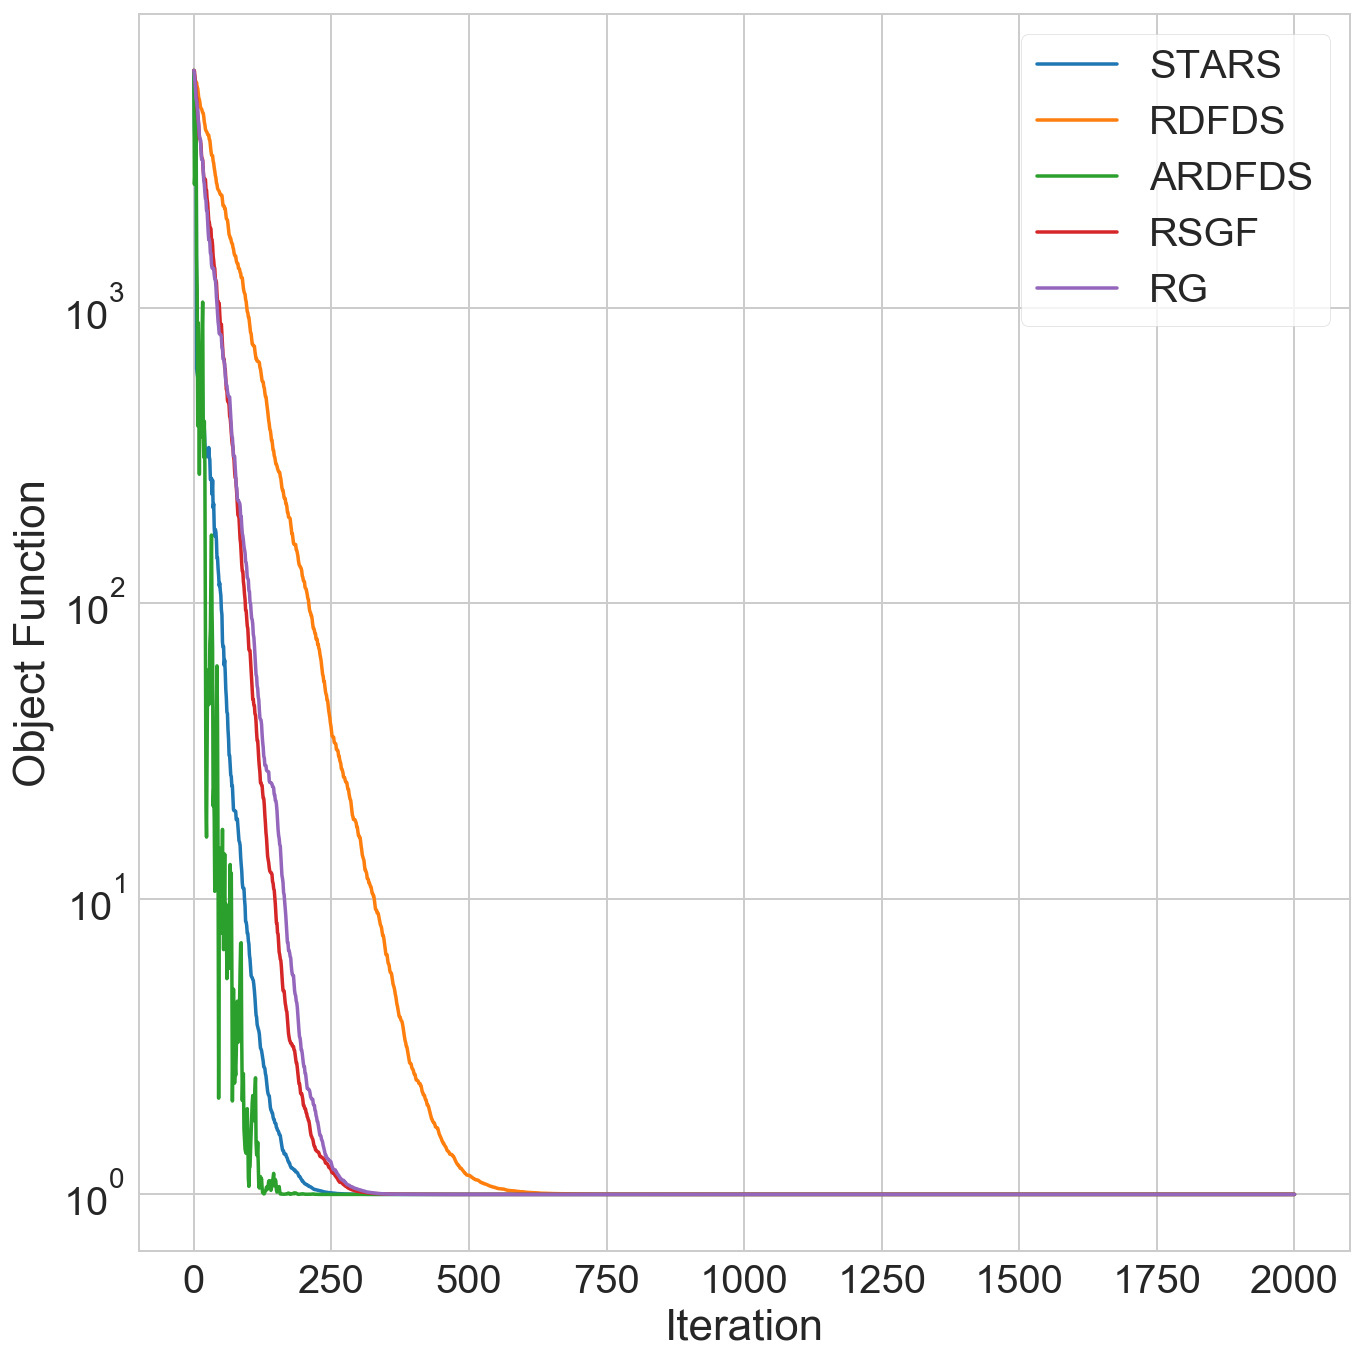

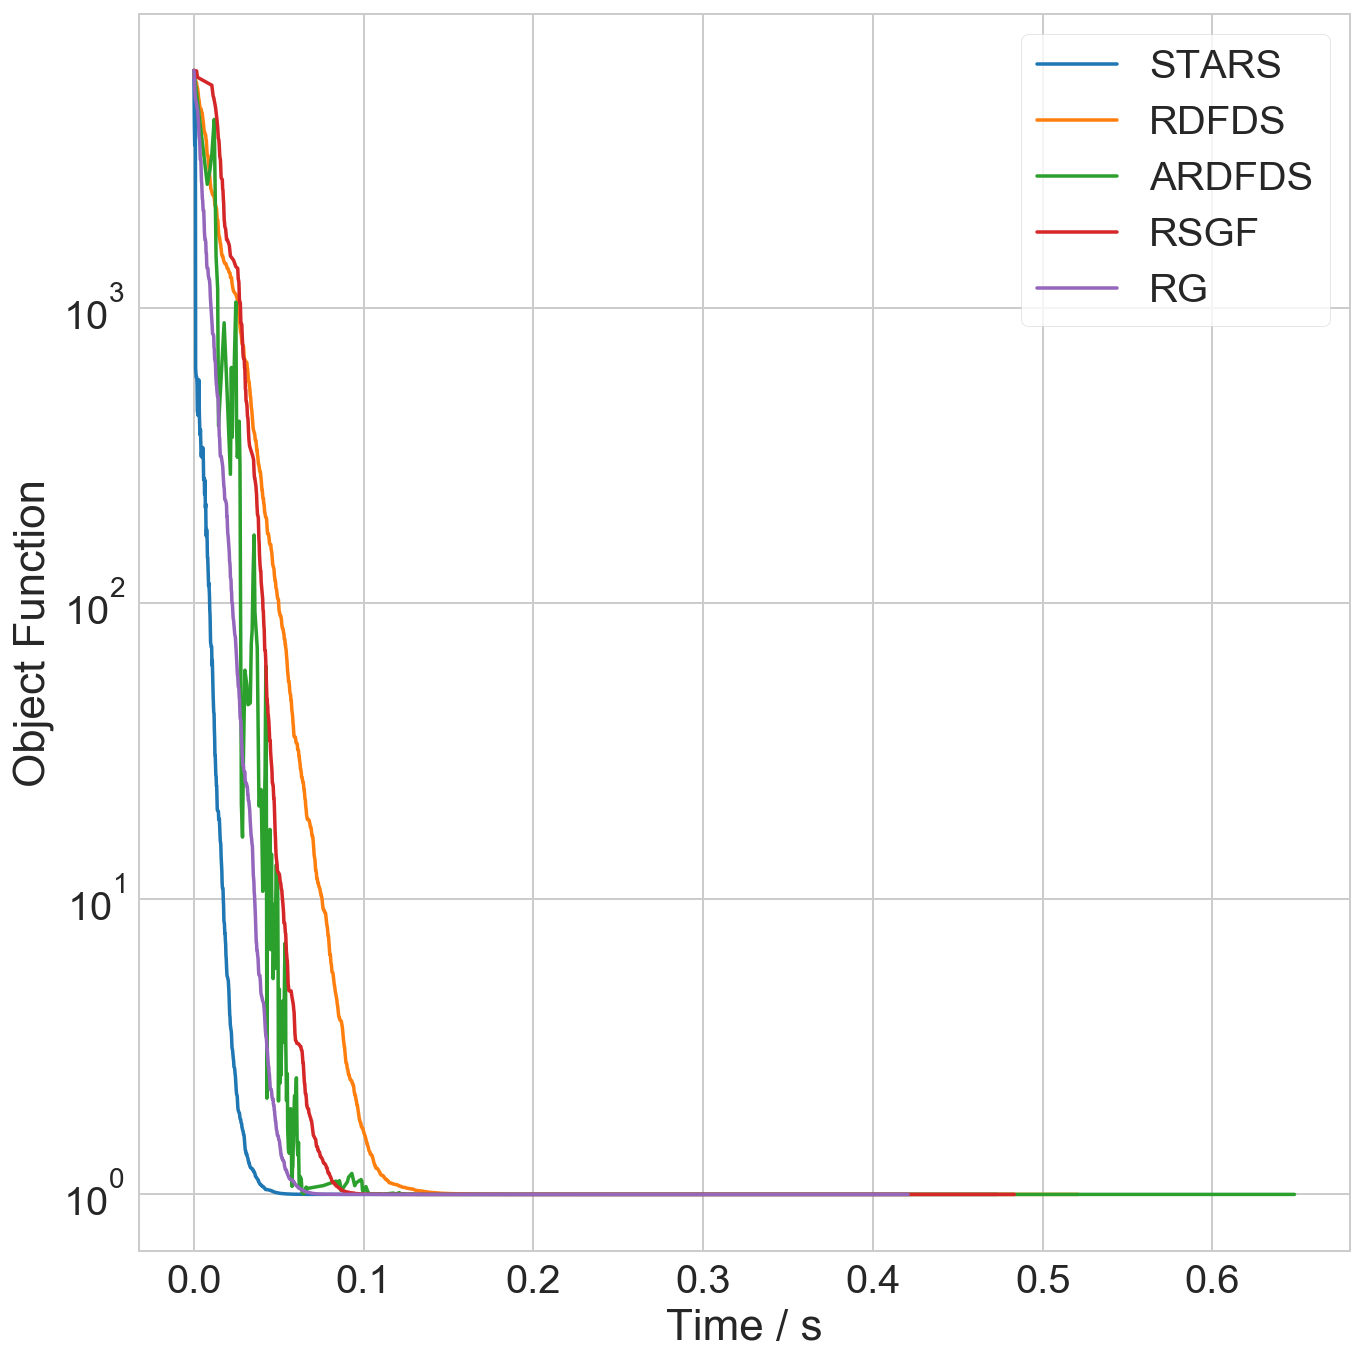

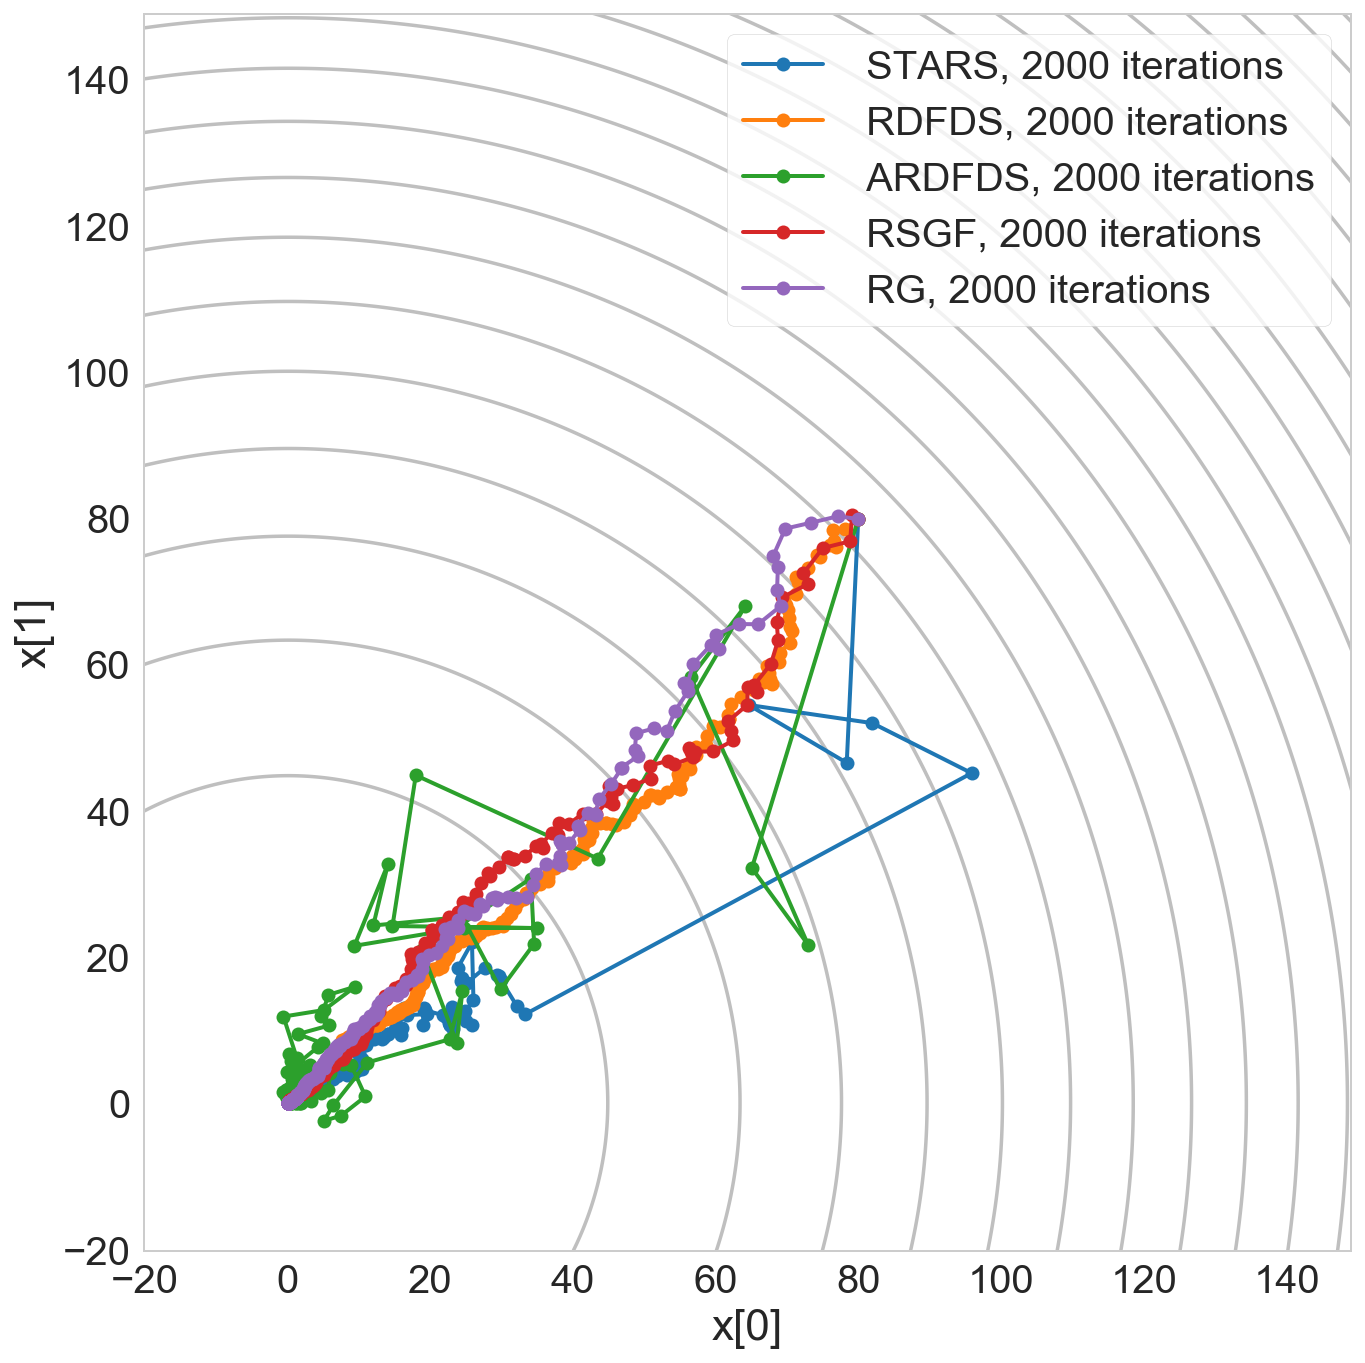

quadratic_function


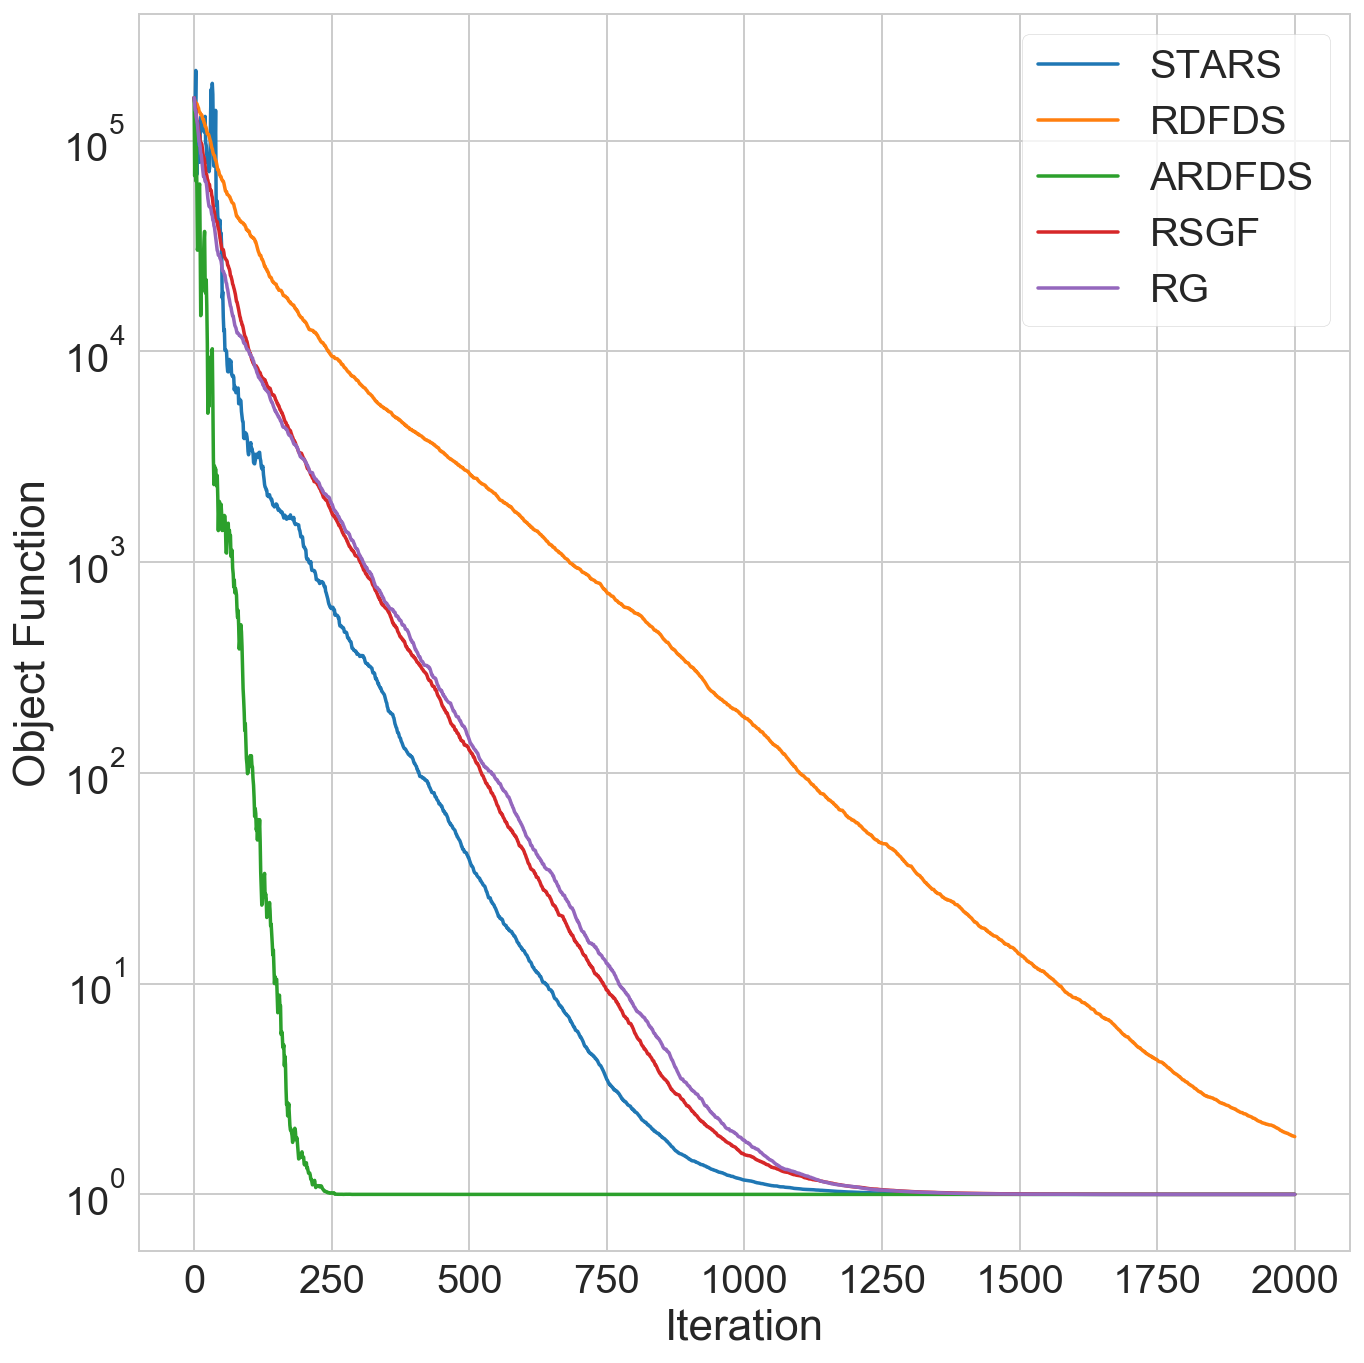

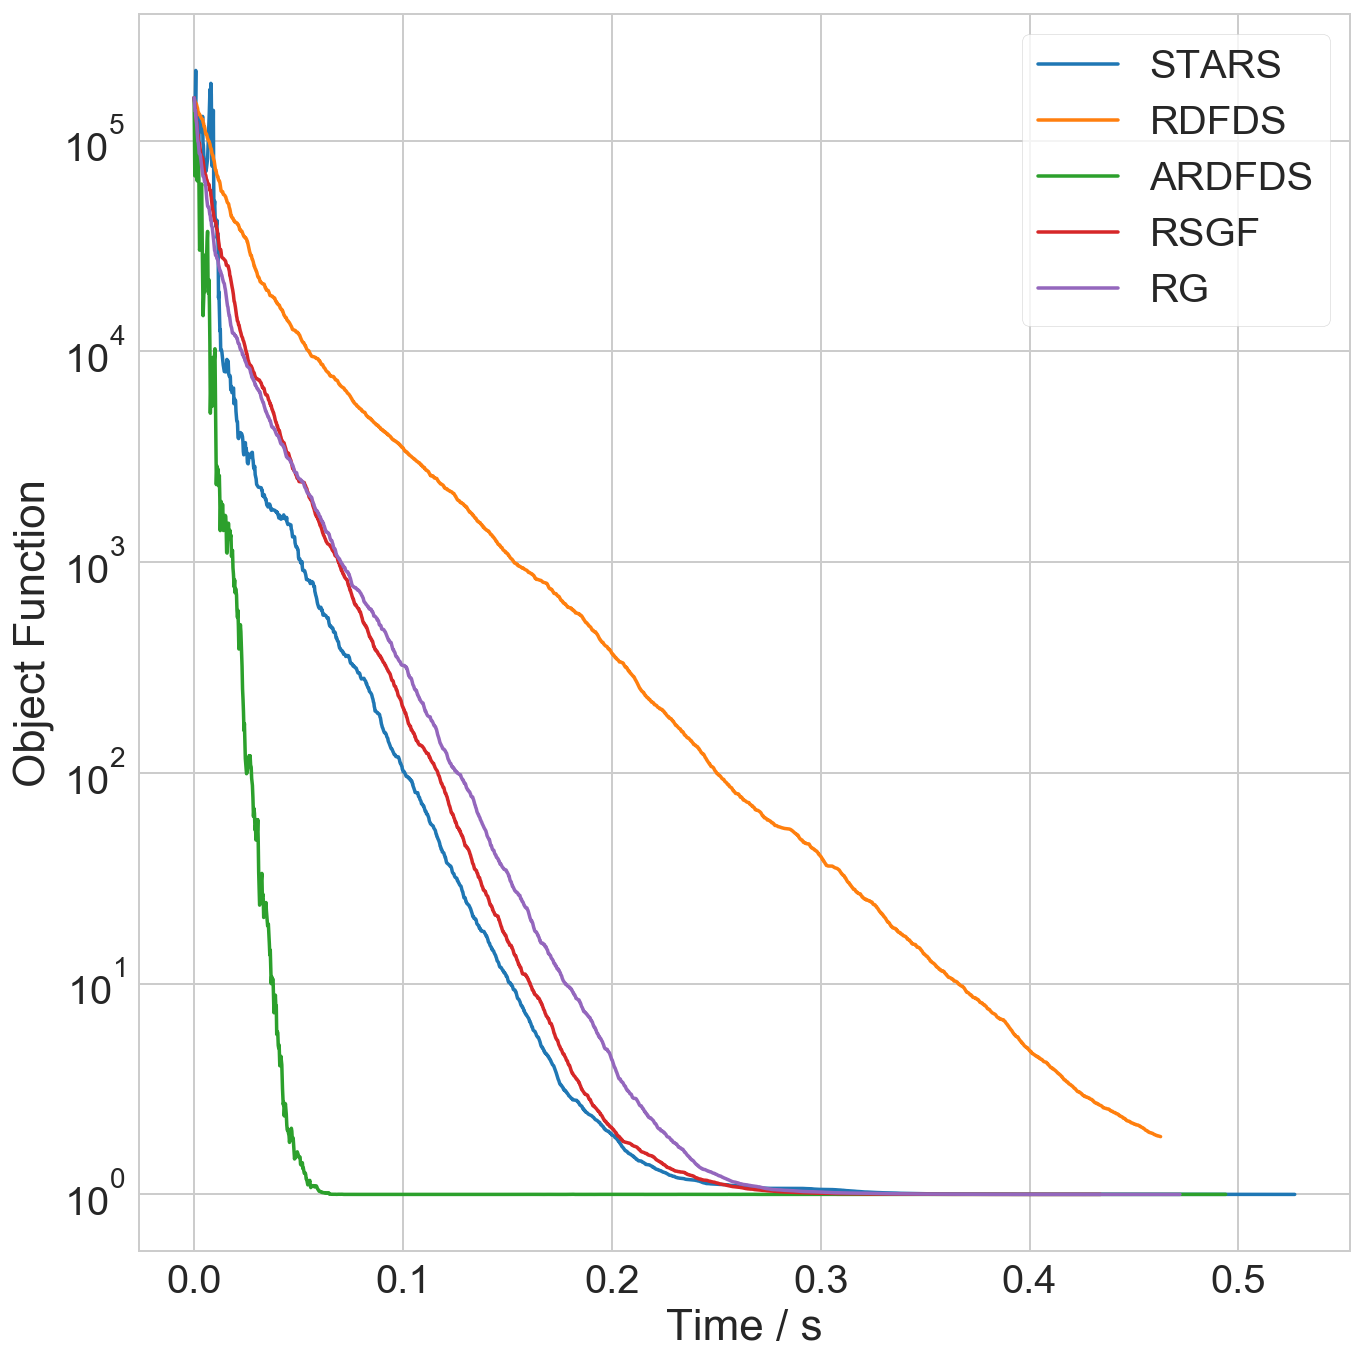

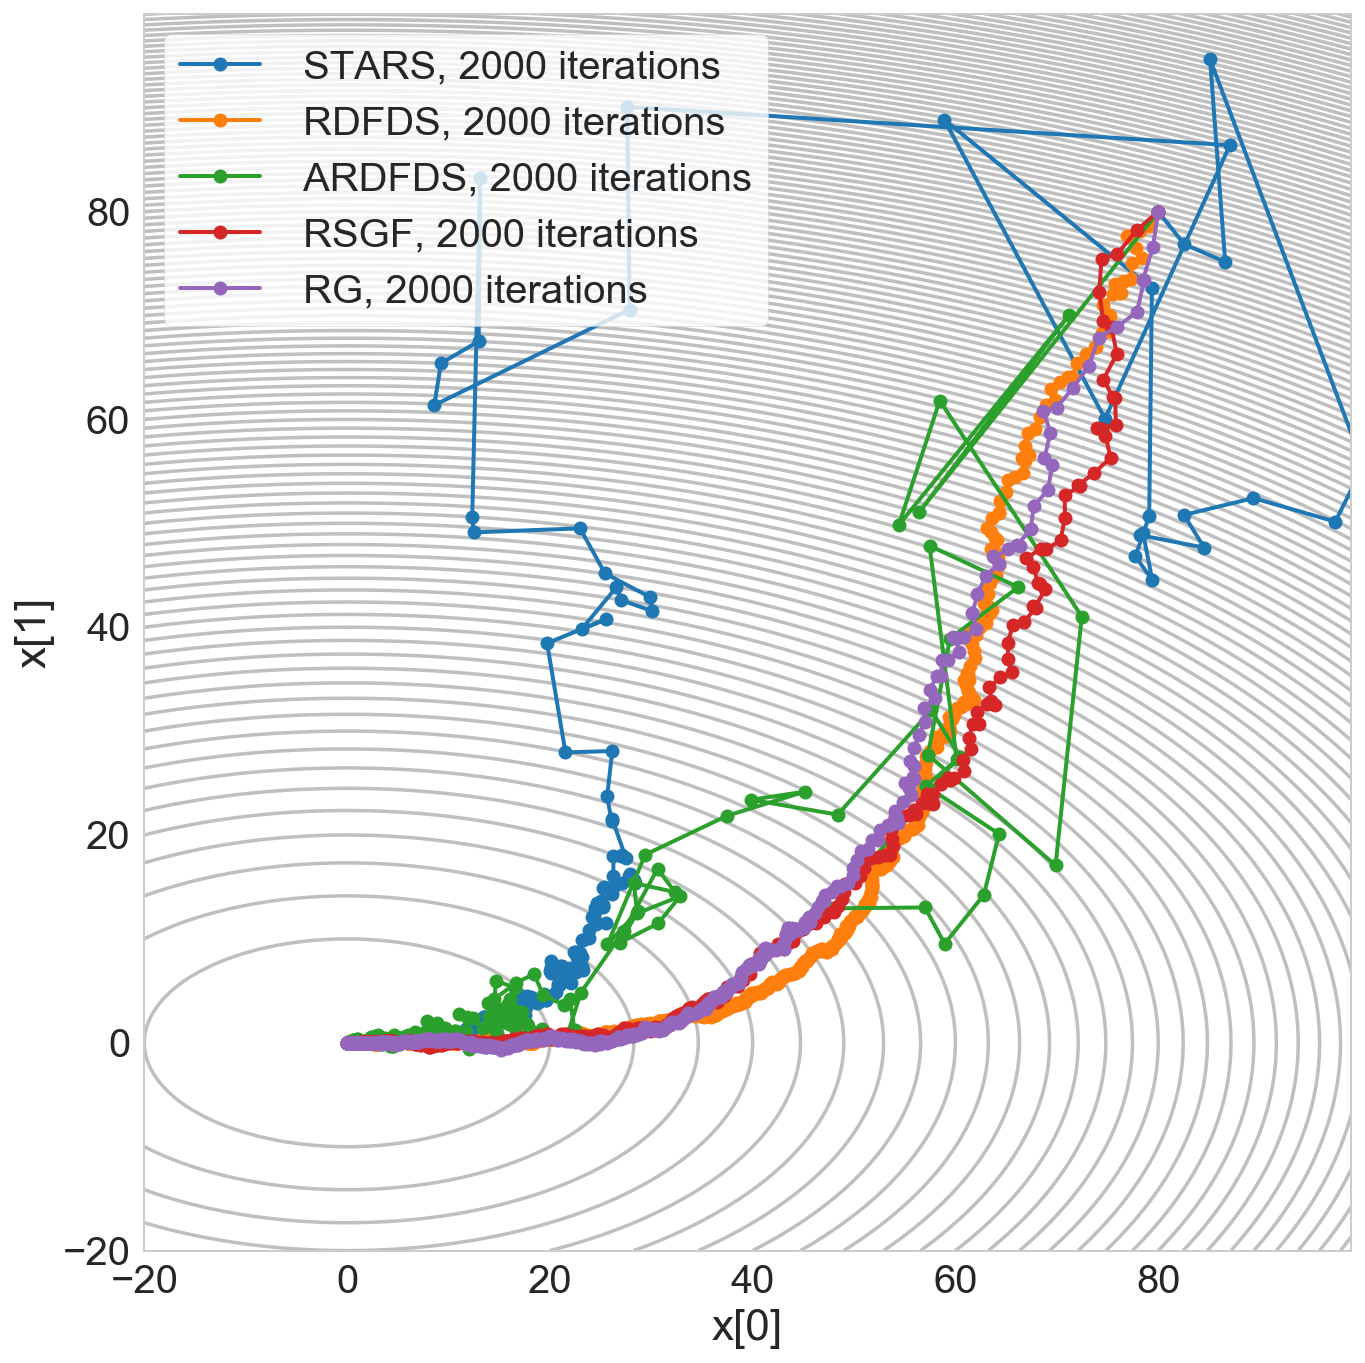

nesterov_function


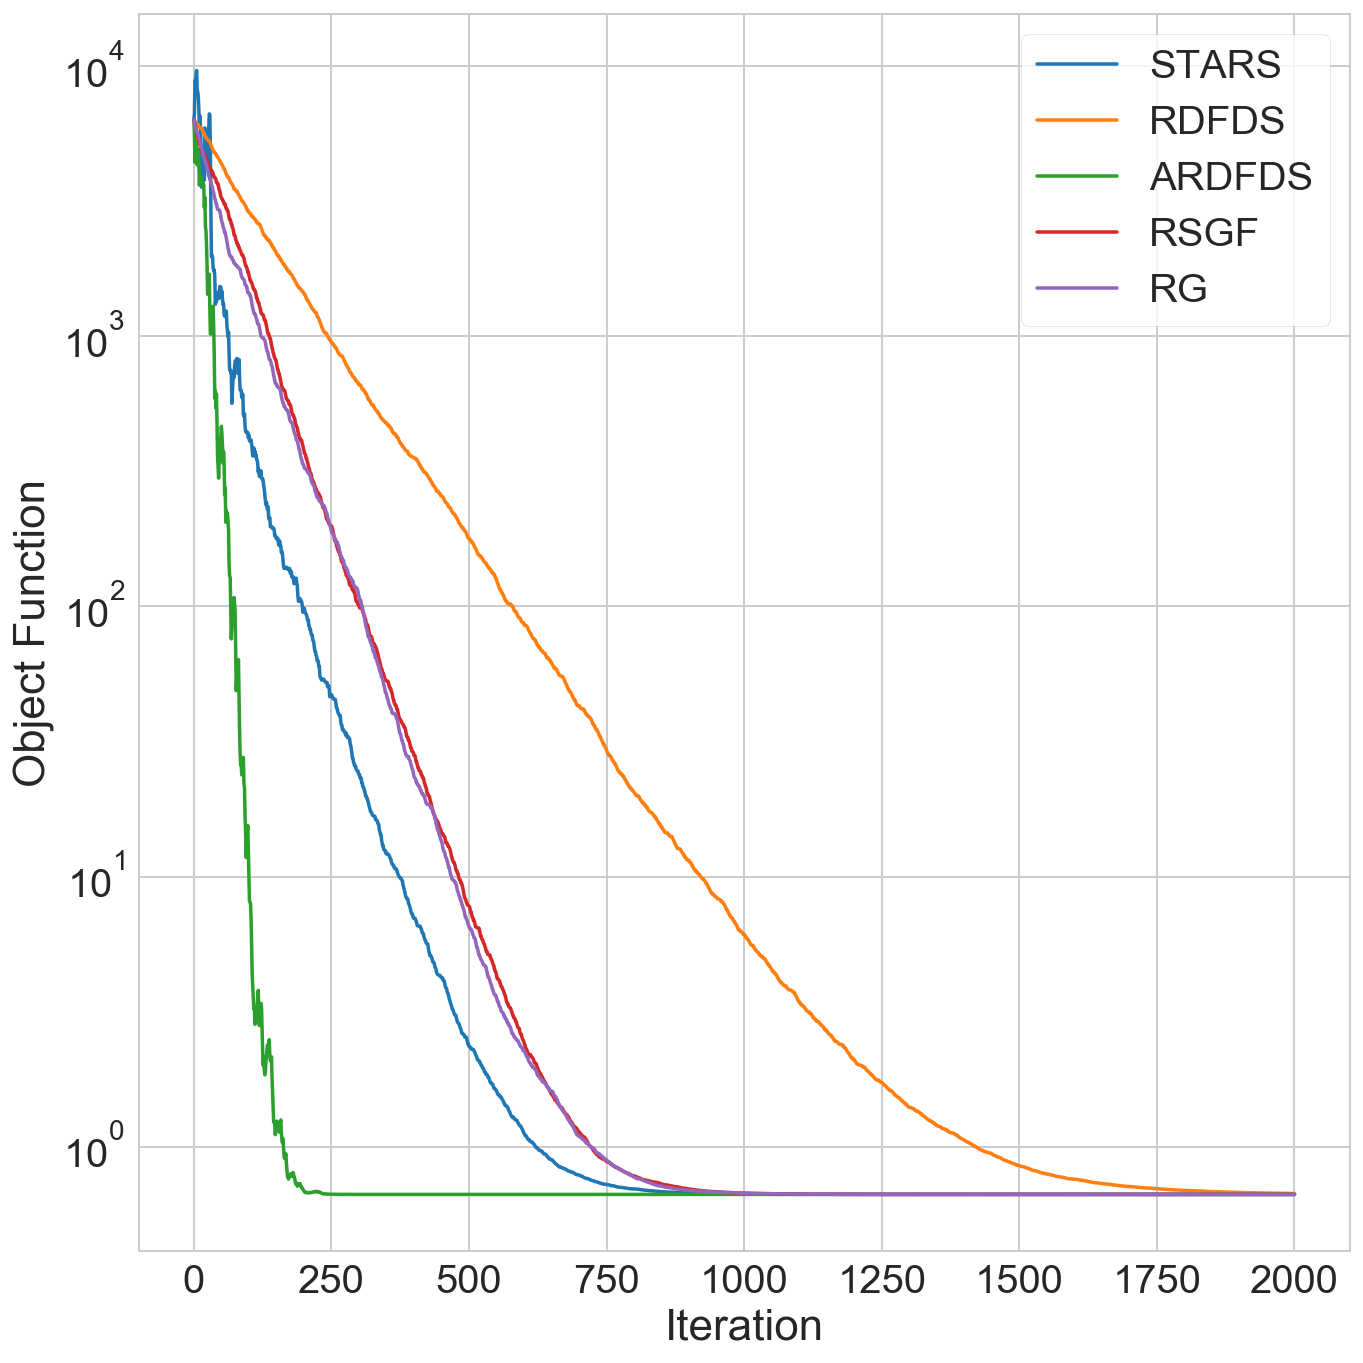

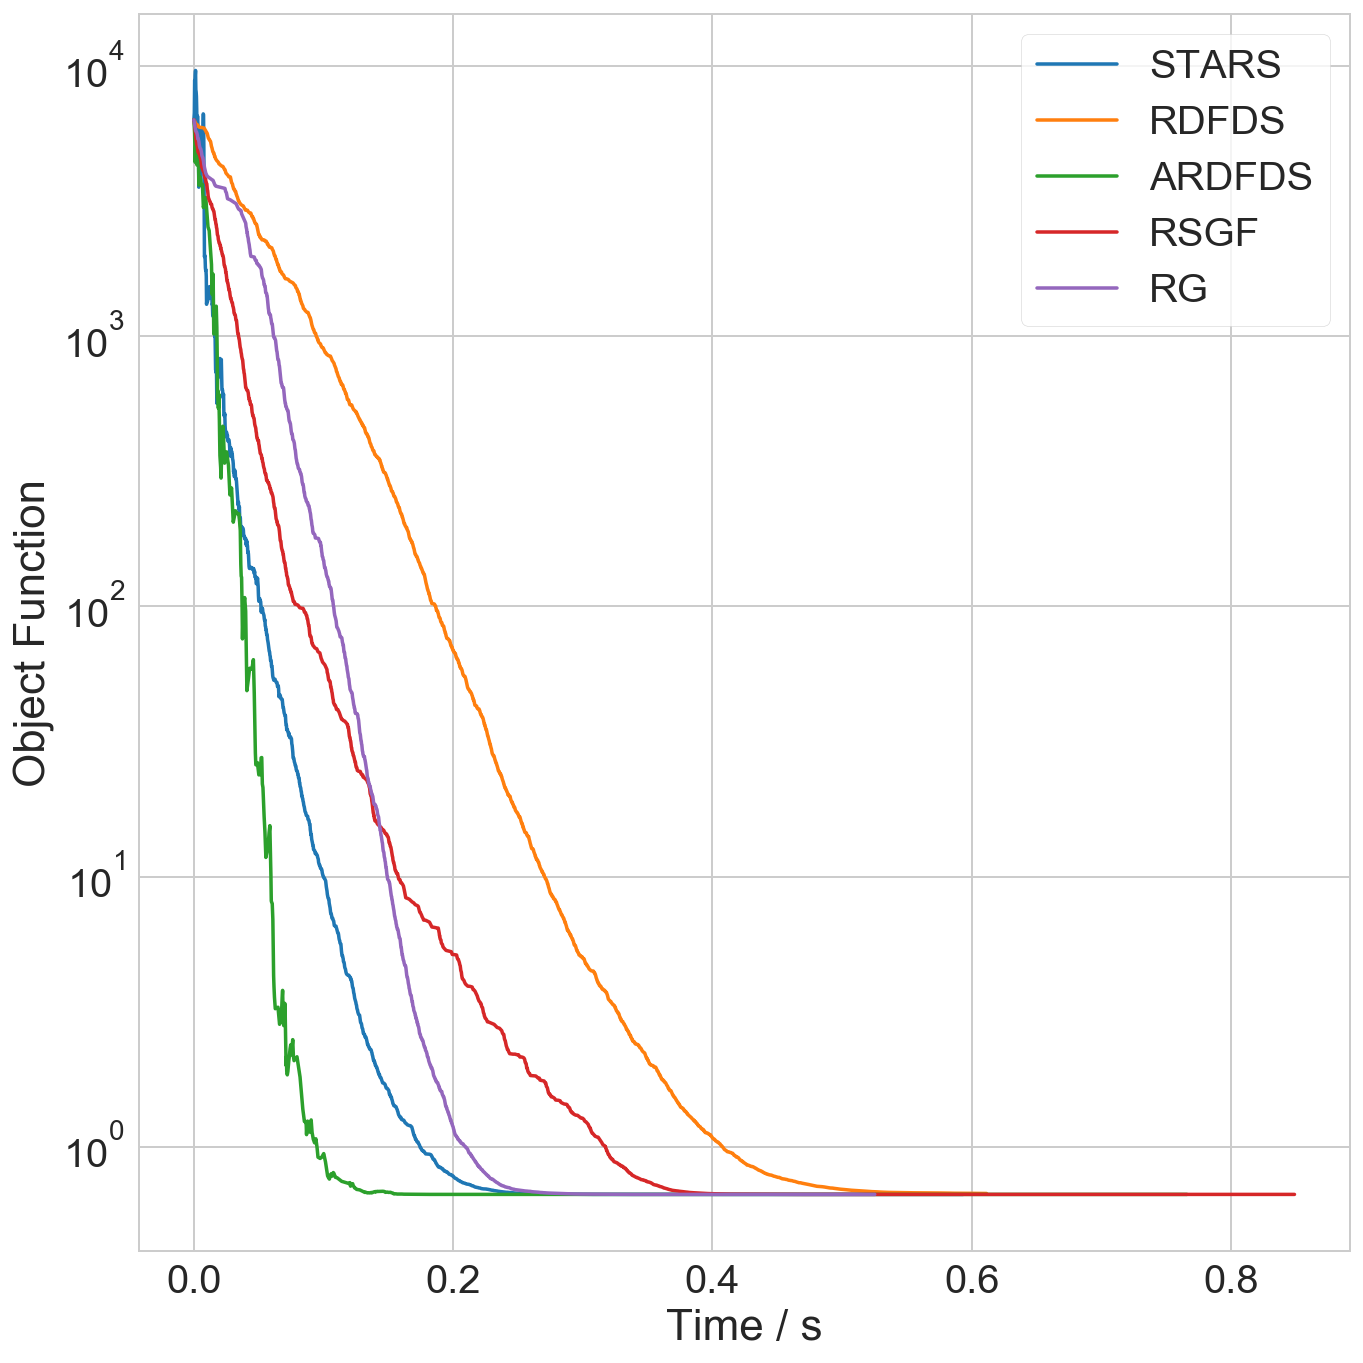

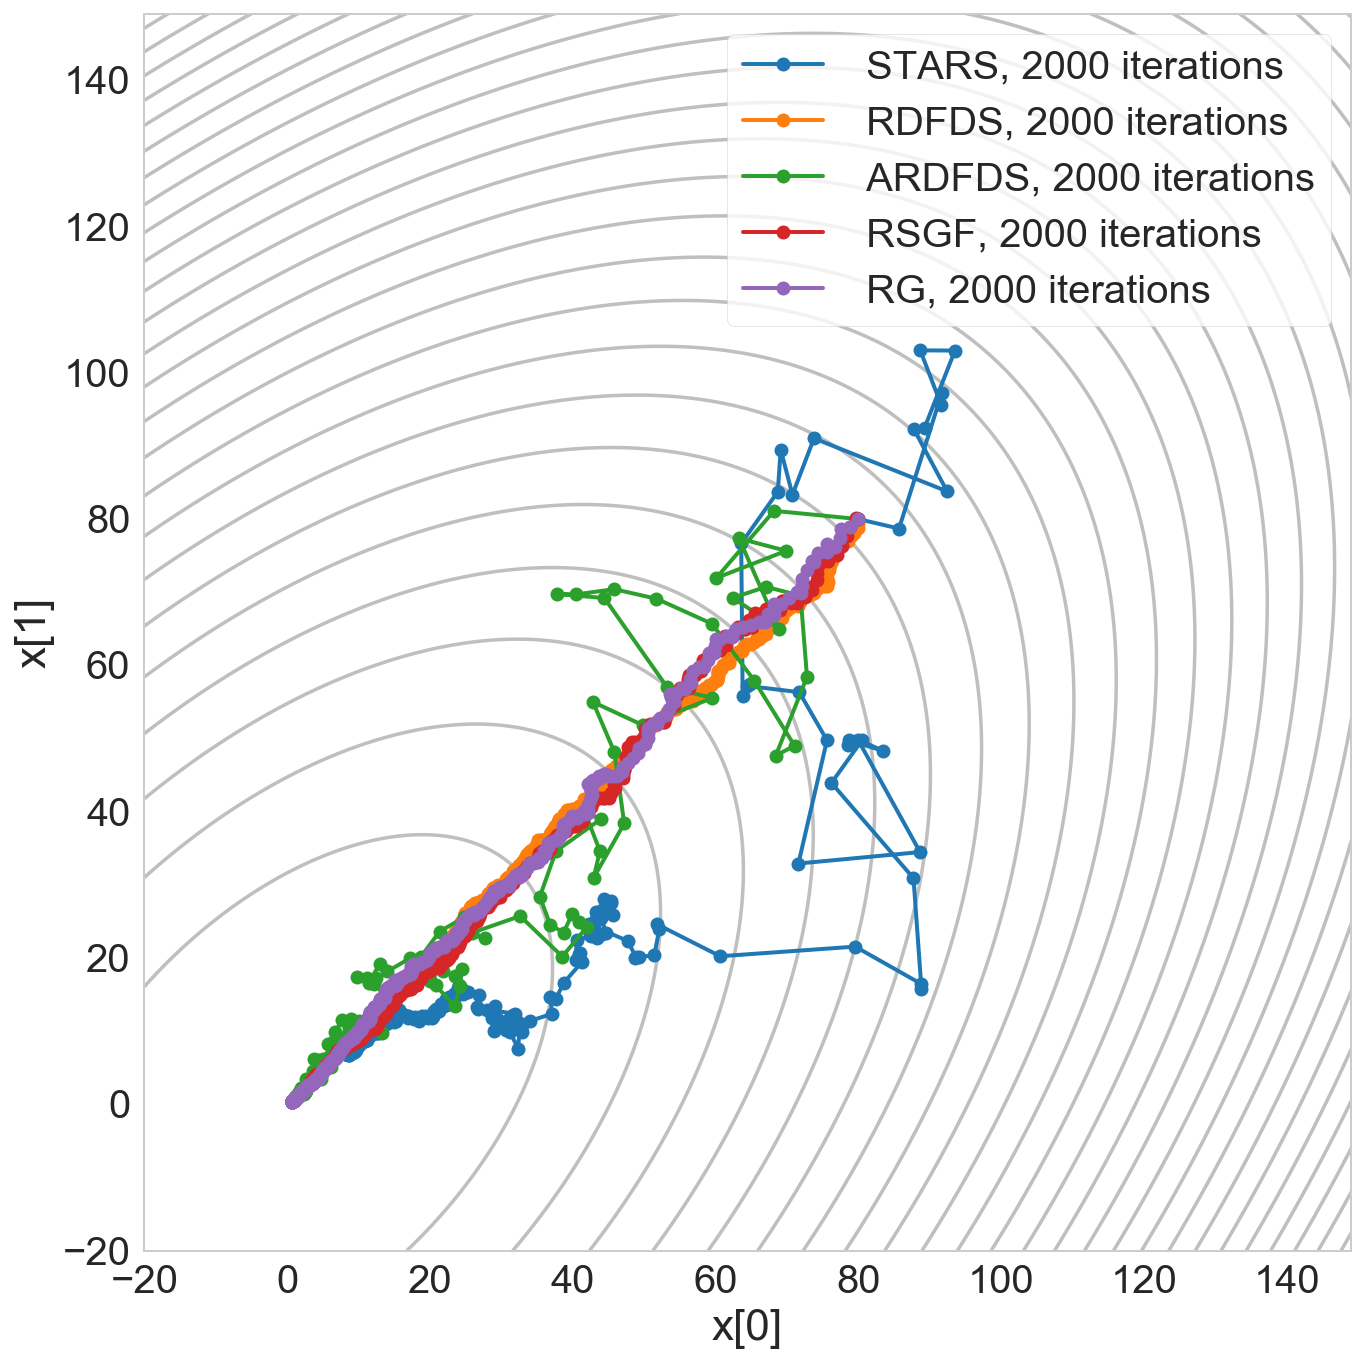

bell_function


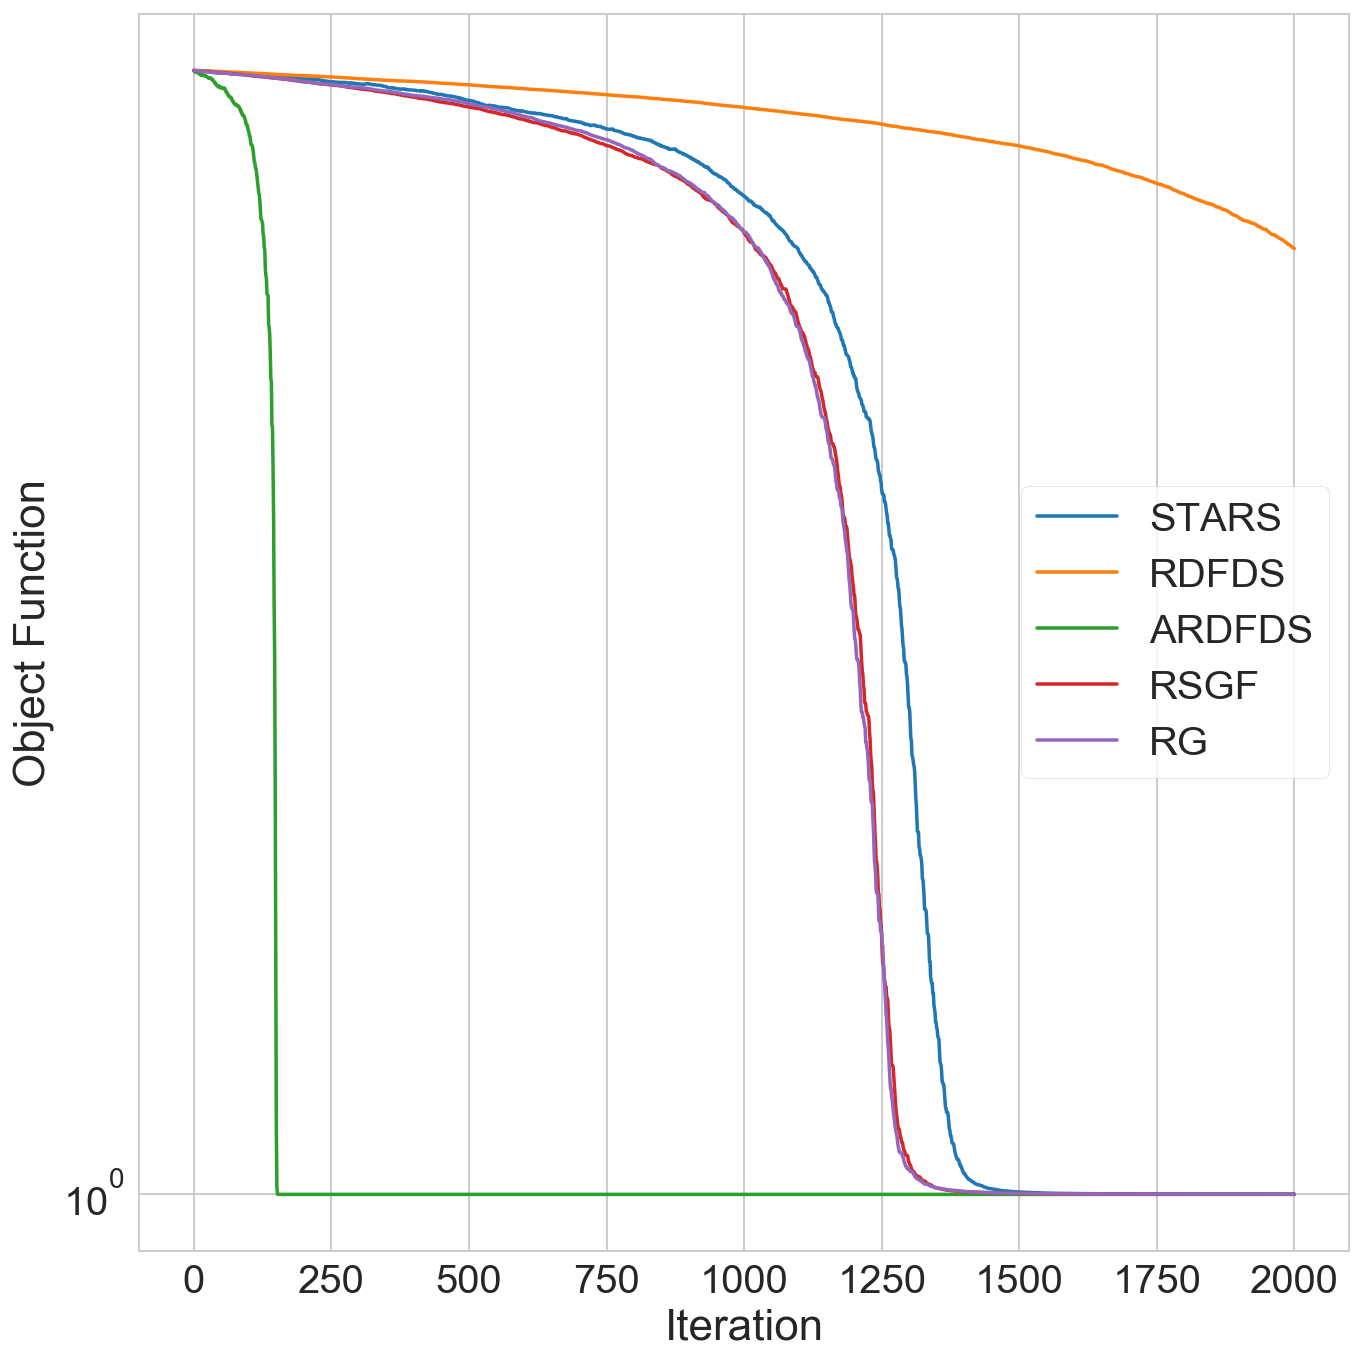

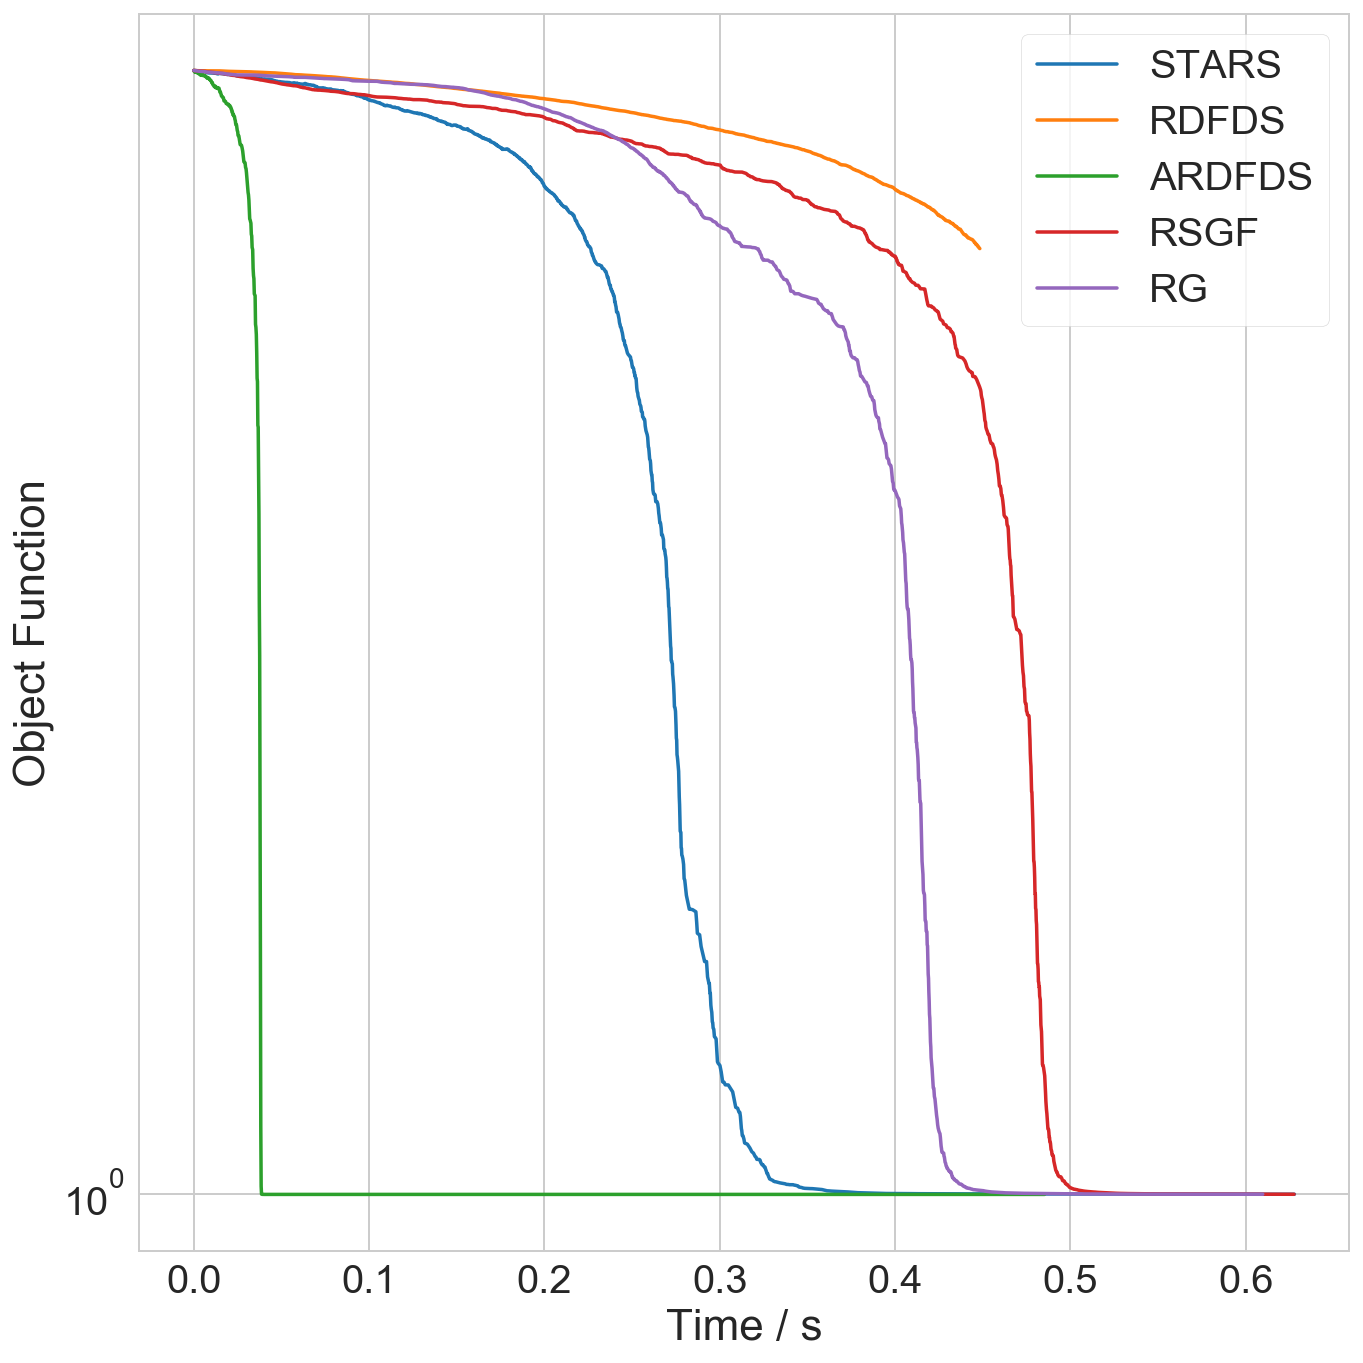

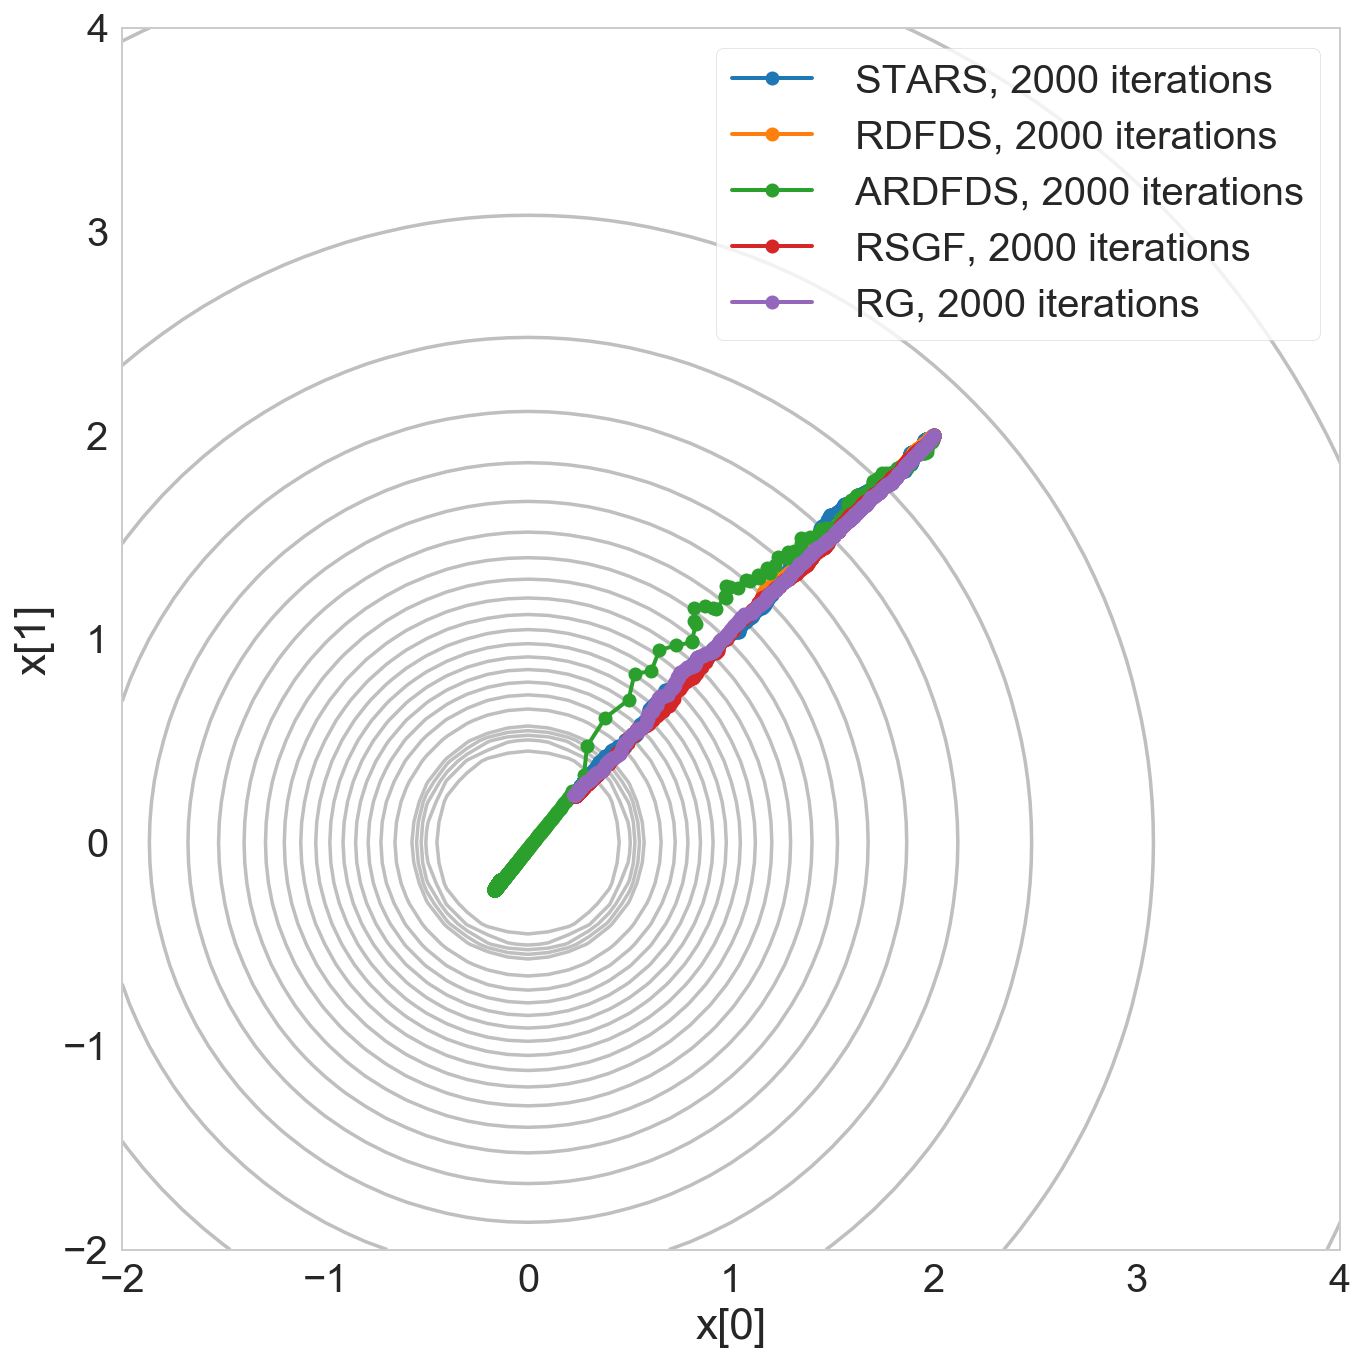

In [54]:
for name in functions:
    print('=========')
    print(name)
    draw_everything(name)

In [52]:
def draw_everything(function_name):
    sigma = 1e-3
    noise_G = gaussian_noise_generator(sigma)
    func=functions[function_name]
    noisy_func = lambda x, n, explicit_noise=None: noisy_function(func, x, noise_G, n, noise_mode="multiply", explicit_noise=explicit_noise)
    if function_name=='bell_function':
        initial_x = np.matrix('2;2')
    else:
        initial_x = np.matrix('80;80')
    N = 2000
    m = 100
    t = 1e-2
    n = initial_x.shape[0]
    L = compute_L(func, n)
    direction_G1 = sphere_point_generator(n)
    direction_G2 = gaussian_point_generator(n)
    results=[]
    results.append(alg.stars(noisy_func, initial_x, L, m, t, noise_generator=noise_G, maximum_iterations=N, direction_generator = direction_G2))
    results.append(alg.rdfds(noisy_func, initial_x, L, m, t, N, direction_generator = direction_G1))
    results.append(alg.ardfds(noisy_func, initial_x, L, m, t, N, direction_generator = direction_G1))
    results.append(alg.rsgf(noisy_func, initial_x, L, m, t, N, direction_generator = direction_G1, initial_stepsize=1000))
    results.append(alg.rg(noisy_func, initial_x, L, m, t, N, direction_generator = direction_G2))
    sns.set_context("notebook", font_scale=2)
    sns.set_style("whitegrid",{'legend.frameon':True})
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    for i in range(len(results)):
        xs=results[i][1]
        ys=get_real_values(func, xs)+1
        ax.plot(ys,label=results[i][3])
    ax.set_yscale("log", nonposy='clip')
    plt.xlabel('Iteration')
    plt.ylabel('Object Function')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./img/%s_0.pdf'%function_name)
    plt.show()
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    for i in range(len(results)):
        xs=results[i][1]
        ts=results[i][2]
        ys=get_real_values(func, xs)+1
        ax.plot(ts,ys,label=results[i][3])
    ax.set_yscale("log", nonposy='clip')
    plt.xlabel('Time / s')
    plt.ylabel('Object Function')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./img/%s_1.pdf'%function_name)
    plt.show()
    sns.set_context("notebook", font_scale=2)
    sns.set_style("whitegrid",{'legend.frameon':True})
    if function_name=='quadratic_function':
        draw_contour(
            func,
            results,
            figsize=(10, 10),
            levels=np.arange(0, 300000, 2000),
            x=np.arange(-20, 100, 0.5),
            y=np.arange(-20, 100, 0.5),
            function_name=function_name
        )
    elif function_name=='bell_function':
        draw_contour(
            func,
            results,
            figsize=(10, 10),
            levels=list(np.arange(0, 0.05, 0.01))+list(np.arange(0.05, 1, 0.05)),
            x=np.arange(-2, 5, 0.1),
            y=np.arange(-2, 5, 0.1),
            function_name=function_name
        )
    else:
        draw_contour(
            func,
            results,
            figsize=(10, 10),
            levels=np.arange(0, 200000, 1000),
            x=np.arange(-20, 150, 0.5),
            y=np.arange(-20, 150, 0.5),
            function_name=function_name
        )